In [1]:
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
pplt.rc.reso='hi'
warnings.filterwarnings('ignore')

In [2]:
FILEDIR = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/data/processed'
SAVEDIR = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/figs'
REGIONS   = {
    'Eastern Arabian Sea':{'latmin':9.,'latmax':19.5,'lonmin':64.,'lonmax':72.}, 
    'Central India':{'latmin':18.,'latmax':24.,'lonmin':76.,'lonmax':83.},
    'Central Bay of Bengal':{'latmin':9.,'latmax':14.5,'lonmin':86.5,'lonmax':90.},
    'Equatorial Indian Ocean':{'latmin':5.,'latmax':10.,'lonmin':62.,'lonmax':67.5},
    'Konkan Coast':{'latmin':15.,'latmax':19.5,'lonmin':69.,'lonmax':72.5}} 
BINPARAMS = {
    'bl':{'min':-0.6,'max':0.1,'width':0.0025},
    'cape':{'min':-70.,'max':20.,'width':1.},
    'subsat':{'min':-20.,'max':70.,'width':1.}}
CASES = {
    'JJ':[(6,'June','#D42028'),(7,'July','#F2C85E')],
    'JA':[(7,'July','#F2C85E'),(8,'August','#5BA7DA')]}
SAMPLETHRESH = 50

In [3]:
def open_dataset(filename,filedir=FILEDIR):
    filepath = f'{filedir}/{filename}'
    ds = xr.open_dataset(filepath)
    return ds

In [4]:
stats = open_dataset('binned_stats.nc')
data  = open_dataset('pr_bl_terms.nc')

In [5]:
def get_region(data,key,regions=REGIONS):
    region = regions[key]
    return data.sel(lat=slice(region['latmin'],region['latmax']),lon=slice(region['lonmin'],region['lonmax']))

def get_month(data,month):
    return data.sel(time=data.time.dt.month==month)

def get_pdf(stats,bintype,precipitating,samplethresh=SAMPLETHRESH):
    if bintype=='1D':
        Q0 = stats.Q0.values
        QE = stats.QE.values
        Q  = QE if precipitating else Q0
        Q[Q<samplethresh] = np.nan
        pdf = Q/np.nansum(Q)
        return xr.DataArray(pdf,coords={'bl':stats.bl.values})
    elif bintype=='2D':
        P0  = stats.P0.values
        PE  = stats.PE.values
        P   = PE if precipitating else P0
        pdf = PE/(np.nansum(P0)*np.diff(stats.subsat.values)[0]*np.diff(stats.cape.values)[0])
        subsatmaxidx,capemaxidx = np.where(P==np.nanmax(P))
        subsatmaxidx,capemaxidx = subsatmaxidx[0],capemaxidx[0]
    return xr.DataArray(pdf,coords={'subsat':stats.subsat.values,'cape':stats.cape.values}),subsatmaxidx,capemaxidx

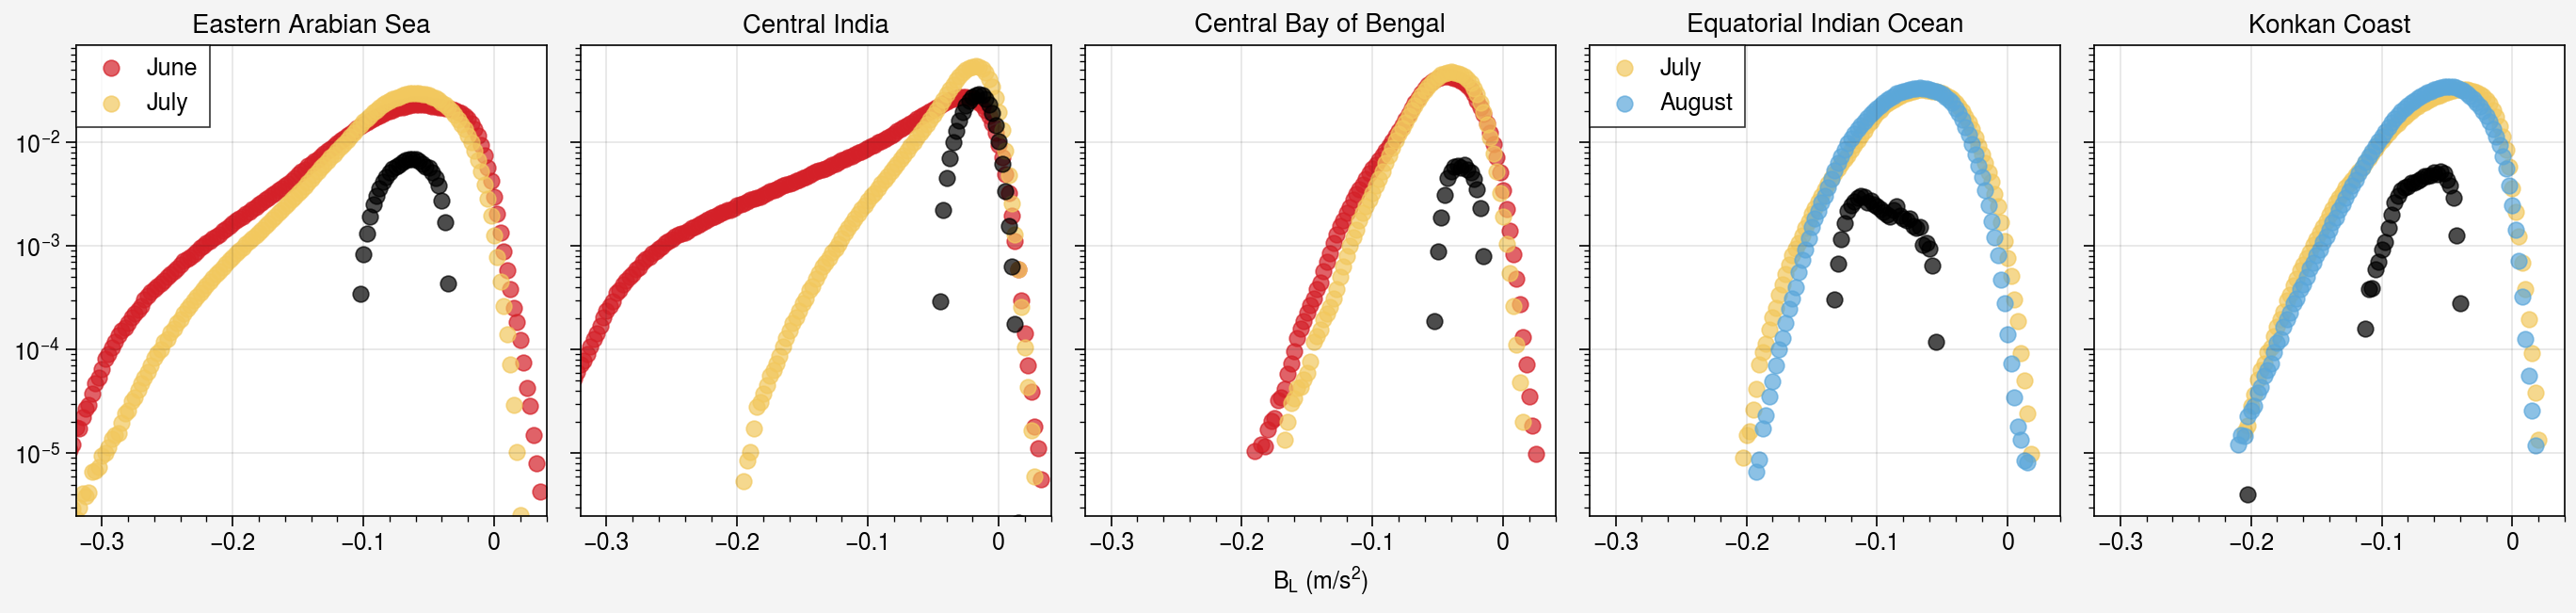

In [20]:
fig,axs = pplt.subplots(nrows=1,ncols=5)
axs.format(xlabel='$B_L$ (m/s$^2$)',xlim=(-0.32,0.04),xticks=0.1,yscale='log',yformatter='log')
for i,region in enumerate(REGIONS):
    axs[i].format(titleloc='c',title=f'{region}')
    casekey = 'JJ' if i<3 else 'JA'
    axnum   = 0 if casekey=='JJ' else 3
    pdflist = []
    for month,label,color in CASES[casekey]:
        monthstats = stats.sel(region=region,month=month)
        pdf = get_pdf(monthstats,bintype='1D',precipitating=False)
        pdflist.append(pdf)
        axs[i].scatter(pdf,color=color,label=label,alpha=0.7)
    pdfdiff = pdflist[1]-pdflist[0]
    axs[i].scatter(pdfdiff,color='k',alpha=0.7)
    axs[axnum].legend(loc='ul',ncols=1)
pplt.show()

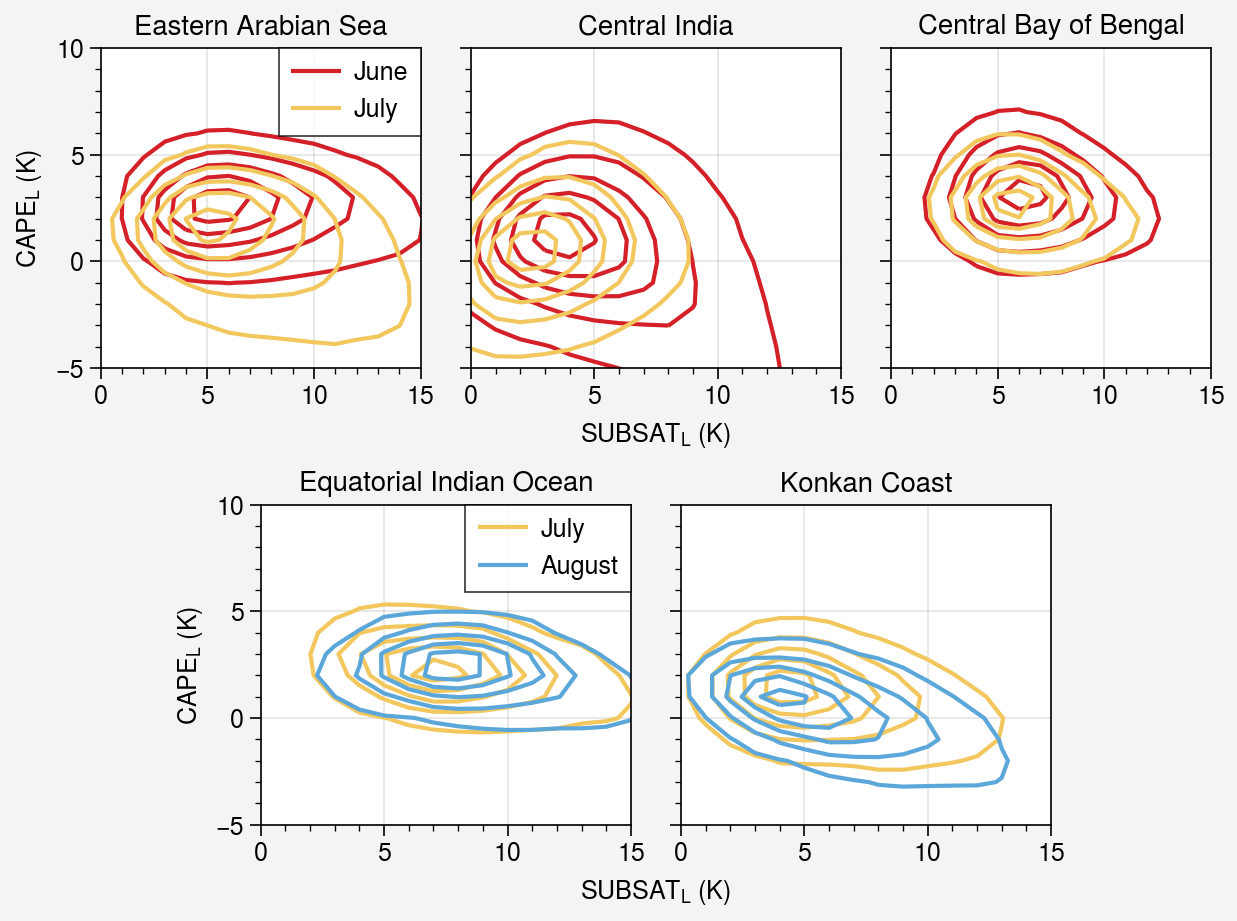

In [21]:
fig = pplt.figure(refaspect=1,refwidth=1.6)
axs = fig.subplots([[1,1,2,2,3,3],[0,4,4,5,5,0]])
axs.format(xlabel='$SUBSAT_L$ (K)',xlim=(0,15),xticks=5,ylabel='$CAPE_L$ (K)',ylim=(-5,10),yticks=5)
for i,region in enumerate(REGIONS):
    axs[i].format(titleloc='c',title=f'{region}')
    casekey = 'JJ' if i<3 else 'JA'
    axnum   = 0 if casekey=='JJ' else 3
    pdflist = []
    keylist = [] 
    for month,label,color in CASES[casekey]:
        monthstats = stats.sel(region=region,month=month)
        pdf,_,_    = get_pdf(monthstats,bintype='2D',precipitating=False)
        pdfmax     = np.nanmax(pdf)
        pdflevels  = np.arange(pdfmax*0.1,pdfmax,pdfmax*0.2)
        pdflist.append(pdf)
        m = axs[i].contour(pdf.T,color=color,levels=pdflevels,label=label)
        keylist.append(m)
    pdfdiff = pdflist[1]-pdflist[0]
    axs[i].contour(pdfdiff,color='k',alpha=0.7)
    axs[axnum].legend(keylist,[CASES[casekey][j][1] for j in range(len(CASES[casekey]))],loc='ur',ncols=1)

pplt.show()
# fig.save(f'{SAVEDIR}/fig_5.png',dpi=600)